In [5]:
import warnings
warnings.filterwarnings('ignore')

### Imports

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import pmdarima as pm
import matplotlib.pyplot as plt

from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

(prices := pd.read_excel("Crude Oil Price.xlsx"))

,Year,Month,Price
0,1946,Jan,19.34
1,1946,Feb,19.45
2,1946,Mar,19.23
3,1946,Apr,20.76
4,1946,May,20.65
...,...,...,...
923,2022,Dec,81.64
924,2023,Jan,79.34
925,2023,Feb,77.05
926,2023,Mar,75.67


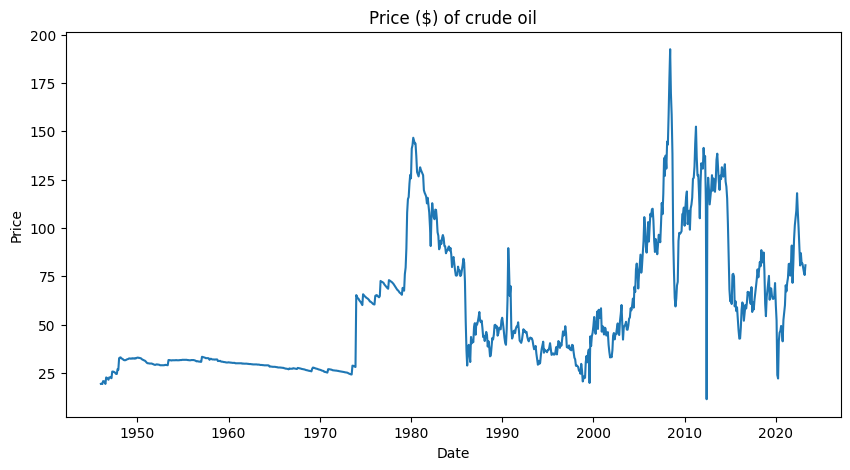

In [38]:
def plot_data():
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    prices["Date"] = pd.to_datetime(prices.Year.astype(str) + " " + prices.Month)
    sns.lineplot(data = prices, y = "Price", x="Date")
    plt.title("Price ($) of crude oil")

plot_data()

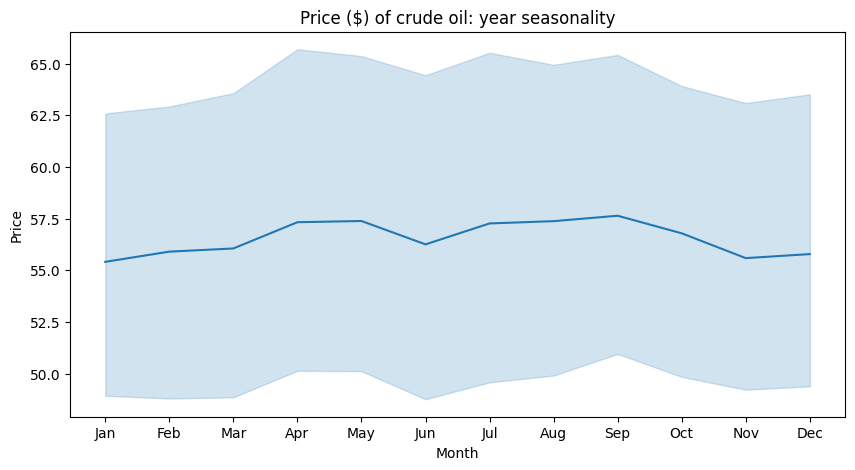

In [39]:
def plot_price_seasonality():
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    sns.lineplot(data = prices, y = "Price", x="Month")
    plt.title("Price ($) of crude oil: year seasonality");

plot_price_seasonality()

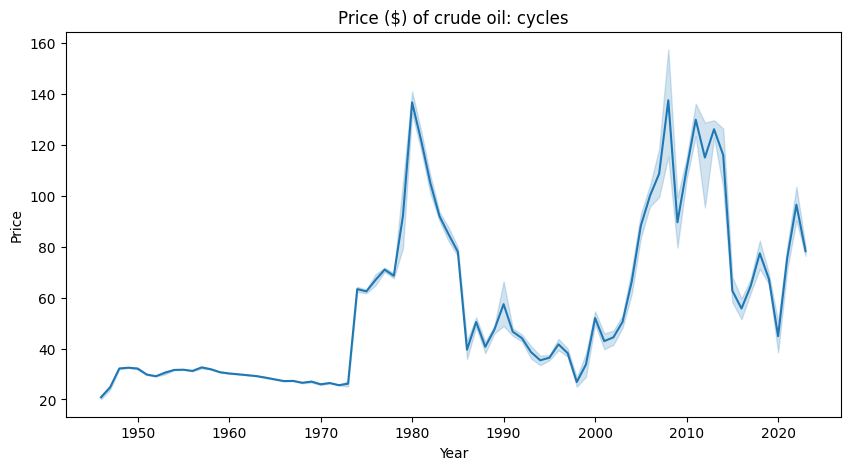

In [40]:
def plot_price_cycles():
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    sns.lineplot(data = prices, y = "Price", x="Year")
    plt.title("Price ($) of crude oil: cycles");

plot_price_cycles()

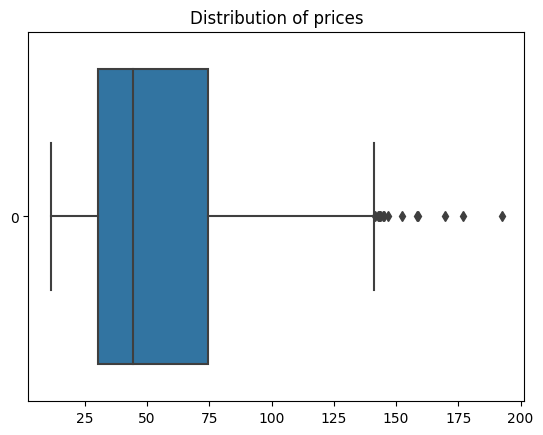

In [41]:
def plot_price_boxplot():
    sns.boxplot(prices.Price, orient="horizontal")
    plt.title("Distribution of prices");

plot_price_boxplot()

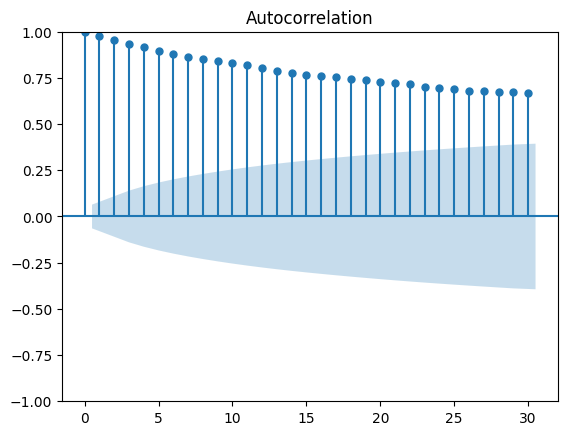

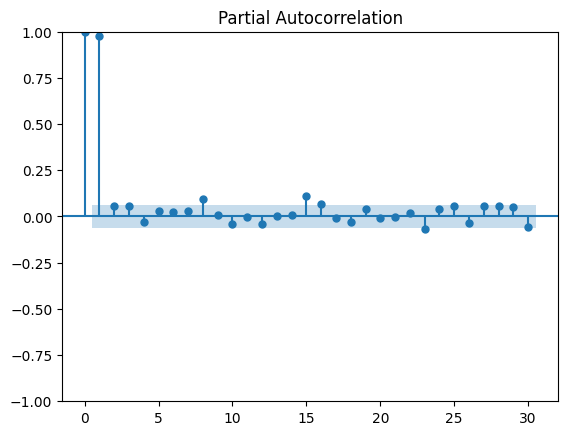

In [42]:
def plot_ACF_PACF(): 
    plot_acf(prices.Price)  
    plot_pacf(prices.Price)

plot_ACF_PACF()

### SARIMA
##### From the plots above we can observe seasonality and trend. 

In [12]:
month_dict = {'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04',
              'May': '05', 'Jun': '06', 'Jul': '07', 'Aug': '08',
              'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'}
prices['month_num'] = prices['Month'].map(month_dict)

prices['Date'] = pd.to_datetime(prices['Year'].astype(str) + '-' + prices['month_num'] + '-01')

prices.drop('month_num', axis=1, inplace=True)

prices['diff_o1'] = np.append([np.nan] * 1, np.diff(prices['Price'], n=1))
prices_o1 = prices.drop(prices.index[0:1])

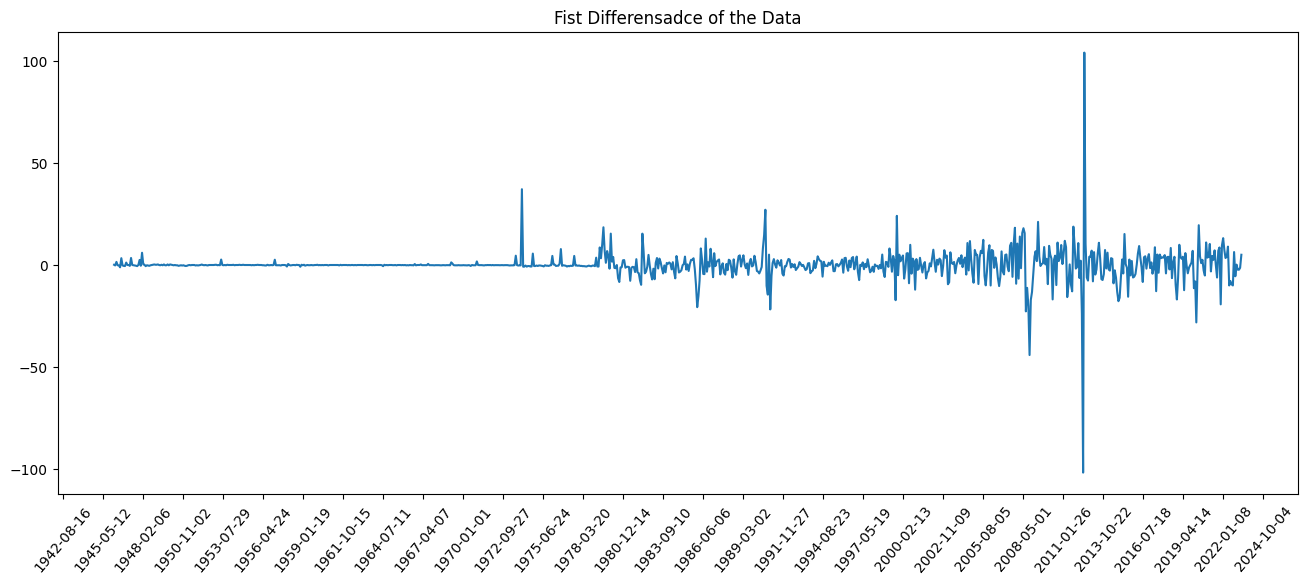

In [43]:
def first_diff():
    plt.figure(figsize=[16, 6])
    plt.plot(prices_o1['Date'],prices_o1['diff_o1'])
    plt.title("Fist Differensadce of the Data")
    plt.xticks(prices_o1['Date'], rotation=50)
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(35))
    plt.show()

first_diff()

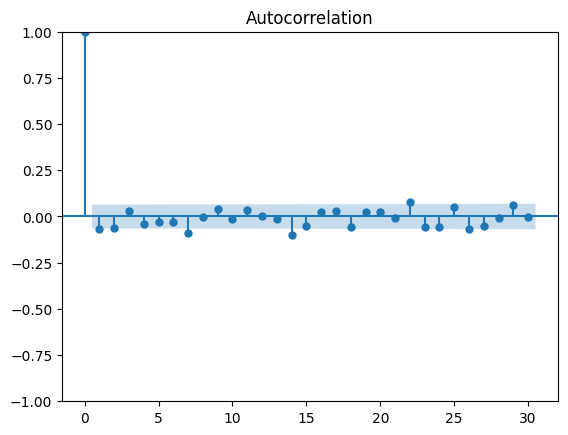

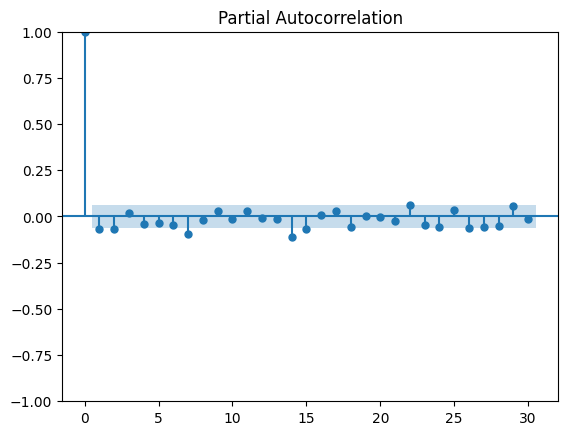

In [44]:
def plot_ACF_PACF_diff():
    plot_acf(prices_o1['diff_o1'], lags=30)
    plot_pacf(prices_o1['diff_o1'], lags=30)
    plt.show()

plot_ACF_PACF_diff()

In [15]:
# Function for checking stationarity using ADF and KPSS tests
def check_stationarity(data, test):
    if (test == 'ADF'):
        result = adfuller(data)
        index = 4
    elif (test == 'KPSS'):
        result = kpss(data)
        index = 3

    print(f'{test} Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[index].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[index]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")


In [45]:
def check_diff_data_stationarity():
    check_stationarity(prices_o1['diff_o1'], 'ADF')
    check_stationarity(prices_o1['diff_o1'], 'KPSS')

check_diff_data_stationarity()

ADF Statistic: -9.895198
p-value: 0.000000
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.568
Stationary
KPSS Statistic: 0.023960
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Non-stationary


##### From the plots and ADF test we can conclude that the differenced data is stationary

In [17]:
# Dividing the data into train and test sets
train = prices[:int(prices.shape[0]*0.9)]
test = prices[int(prices.shape[0]*0.9):]

In [18]:
model = ARIMA(train['Price'], order=(1,1,1))
model_fit = model.fit() 
sarima_forecast = model_fit.forecast(len(test))

In [46]:
def lb_test():
    residuals = model_fit.resid
    a=acorr_ljungbox(residuals, lags=12)
    a_df=pd.DataFrame(a,columns=['lb_pvalue'])
    a_df.index = np.arange(1, len(a_df)+1)
    print(a_df)

lb_test()

    lb_pvalue
1    0.534403
2    0.761312
3    0.182826
4    0.300800
5    0.428638
6    0.522263
7    0.203719
8    0.276831
9    0.138345
10   0.188342
11   0.170825
12   0.223171


In [47]:
def auto_arima():
    model2 = pm.auto_arima(train['Price'], start_p=1, start_q=1,
                        test='adf',       
                        max_p=3, max_q=3, 
                        m=12,             
                        d=None,           
                        seasonal=True,  
                        start_P=0, 
                        D=None, 
                        trace = False,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)
    print(model2.summary())

auto_arima()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  835
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2828.525
Date:                Thu, 11 May 2023   AIC                           5663.050
Time:                        21:43:51   BIC                           5677.229
Sample:                             0   HQIC                          5668.486
                                - 835                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8399      0.026     32.838      0.000       0.790       0.890
ma.L1         -0.9144      0.027    -33.915      0.000      -0.967      -0.862
sigma2        51.6782      0.459    112.594      0.0

The mean squared error for the SARIMAX model is 325.259961769338


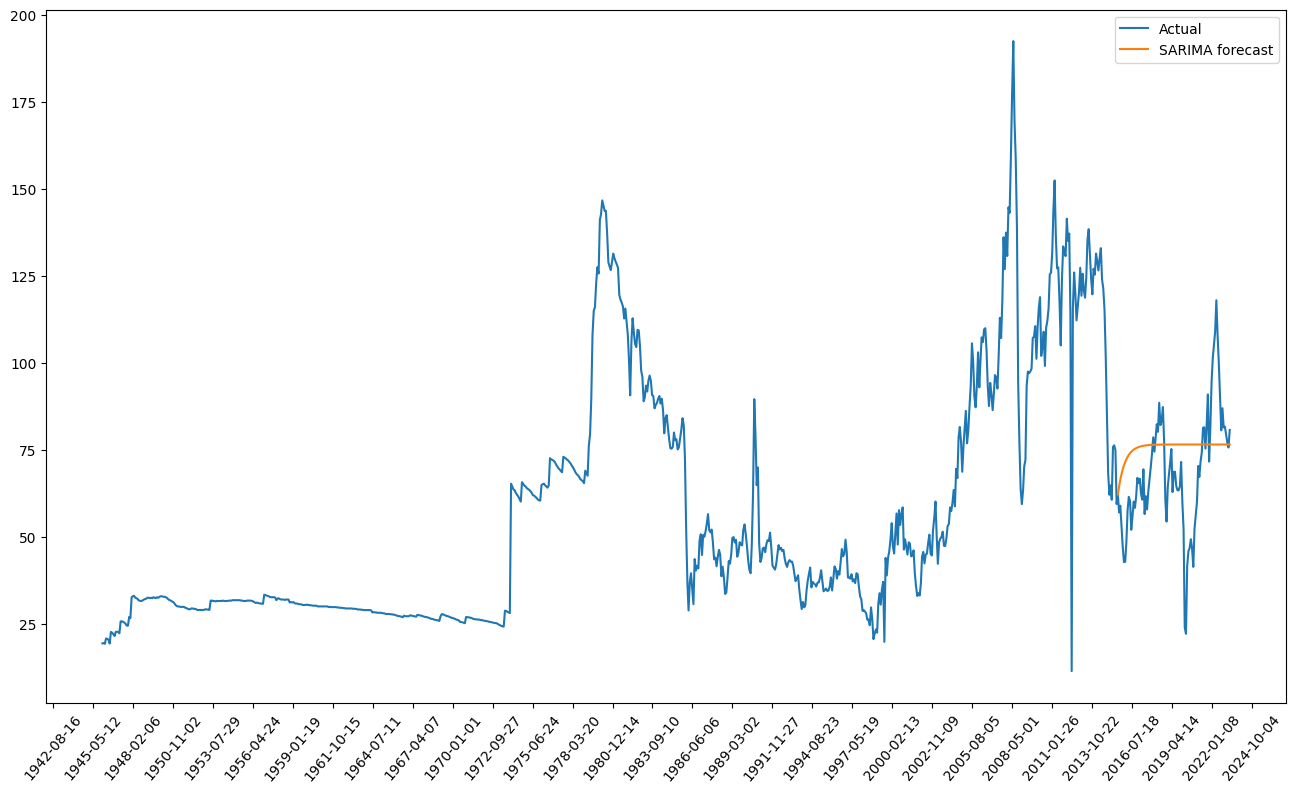

In [48]:
sarima_pred = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

mse = mean_squared_error(test['Price'], sarima_pred)

def forecast_with_sarima():
    print(f"The mean squared error for the SARIMAX model is {mse}")

    plt.figure(figsize=(16,9))
    plt.plot(prices.Date, prices['Price'], label='Actual')
    plt.plot(test.Date, sarima_pred, label='SARIMA forecast')
    plt.xticks(prices.Date, rotation=50)
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(35))
    plt.legend()
    plt.show()

forecast_with_sarima()

### Holt Winter
#### From the visualizations above we notice that wherever a trend is present it is additive, and thus we will do exponential smoothing with additive trend. Also, we see that our series are fluctuating a lot around the trend, thus we will pick additive seasonality.

In [22]:
hw_model = ExponentialSmoothing(train['Price'],trend='add',seasonal='mul',seasonal_periods=12)
fitted_hw = hw_model.fit()

In [23]:
train['HWES'] = fitted_hw.fittedvalues

In [49]:
preds = fitted_hw.forecast(len(test))

def HW_mse():
    hw_mse = mean_squared_error(preds, test['Price'])
    print(f"The mean squared error for the Holt Winter's model is {hw_mse}")

HW_mse()

The mean squared error for the Holt Winter's model is 303.073178839844


#### The MSE for Halt-Winter is better than for the best SARIMA model
#### Fitting the model on full data

In [25]:
hw_full_model = ExponentialSmoothing(prices['Price'], trend='add', seasonal='add', seasonal_periods=12)
fitted_full_hw = hw_full_model.fit()
prices['HWES'] = fitted_full_hw.fittedvalues
hw_forecast = fitted_full_hw.forecast(len(test))

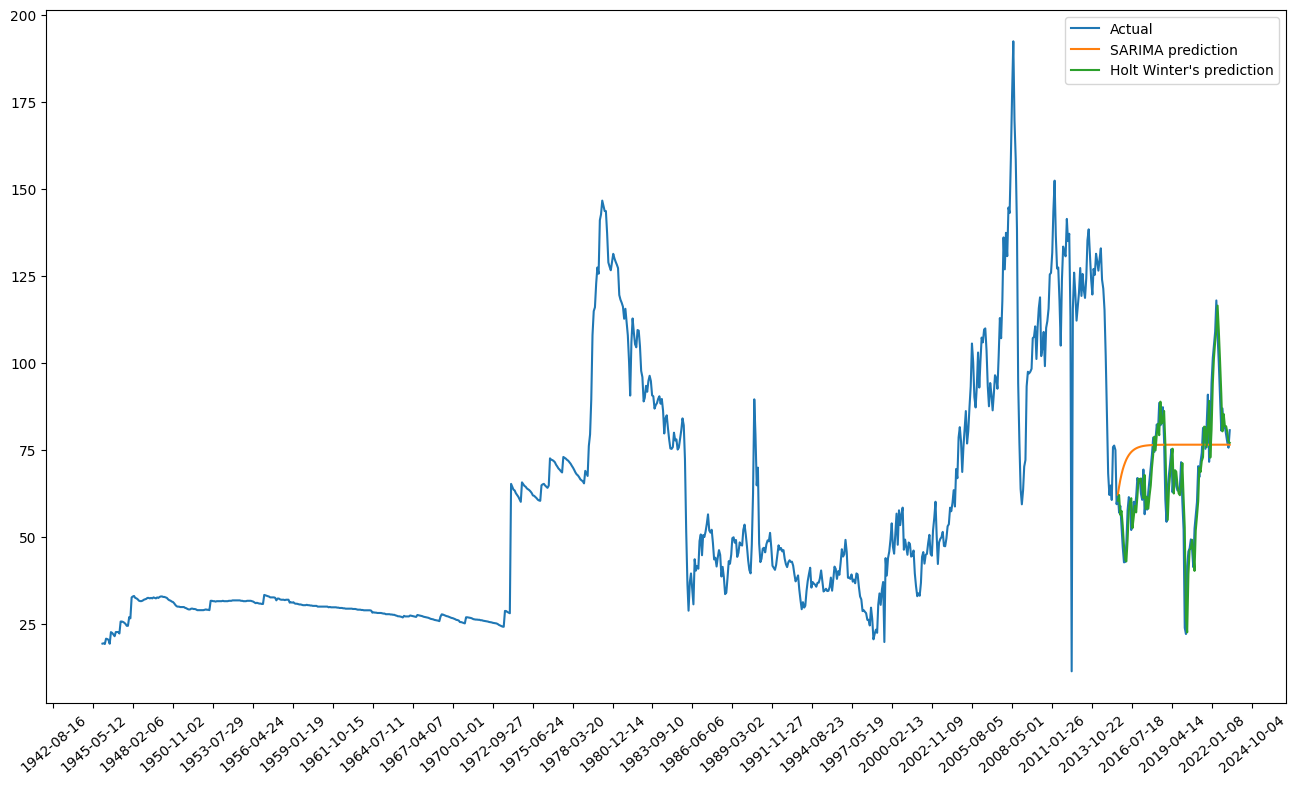

In [50]:
def plot_HW_pred():
    plt.figure(figsize=(16,9))
    plt.plot(prices.Date, prices.Price, label="Actual")
    plt.plot(test.Date, sarima_pred, label="SARIMA prediction")
    plt.plot(test.Date, prices.HWES[len(train):], label="Holt Winter's prediction")
    plt.xticks(prices.Date, rotation=40)
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(35))
    plt.legend()
    plt.show()

plot_HW_pred()

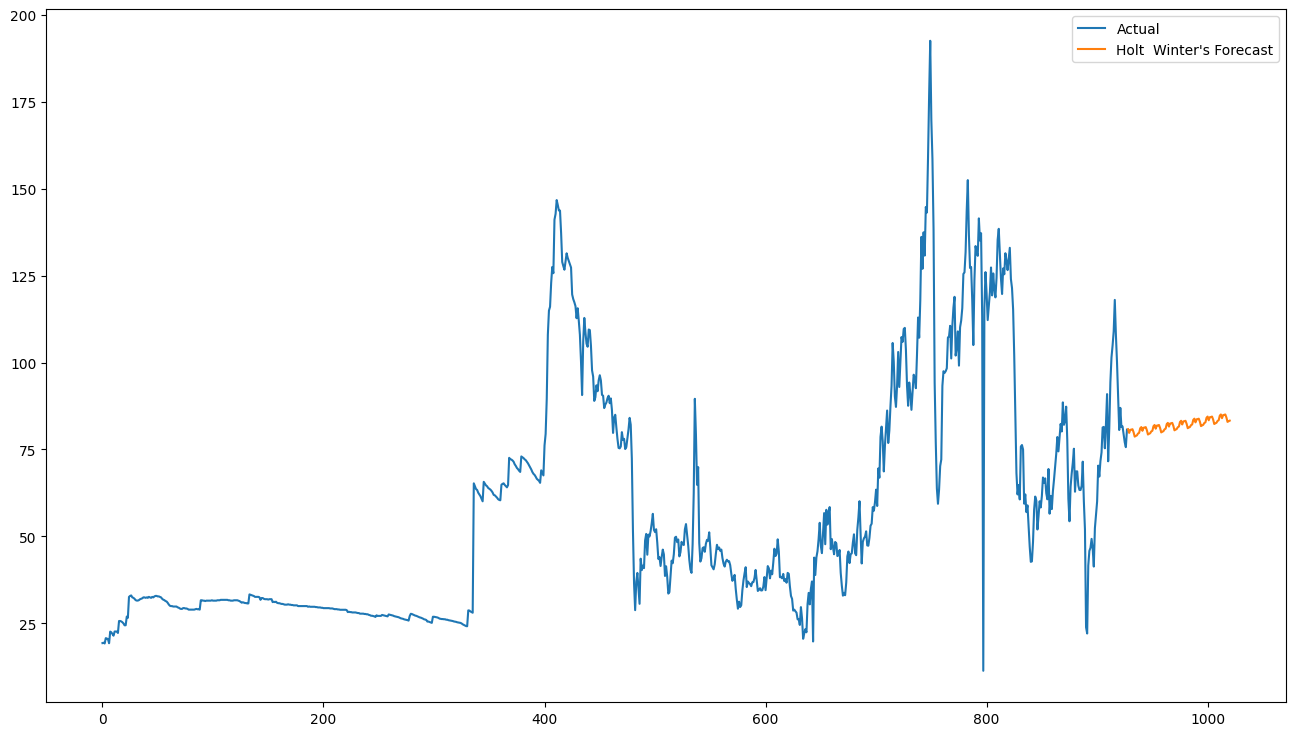

In [51]:
def plot_HW_forecast():
    plt.figure(figsize=(16,9))
    plt.plot(prices.Price, label="Actual")
    plt.plot(hw_forecast, label="Holt  Winter's Forecast")
    plt.legend()
    plt.show()

plot_HW_forecast()

#### We see that though mse-s of the two models are close, Holt-Winter's exponential smoothing has much more realistic forecast.

## Applying GARCH

In [28]:
returns = 100*prices['Price'].pct_change().dropna()

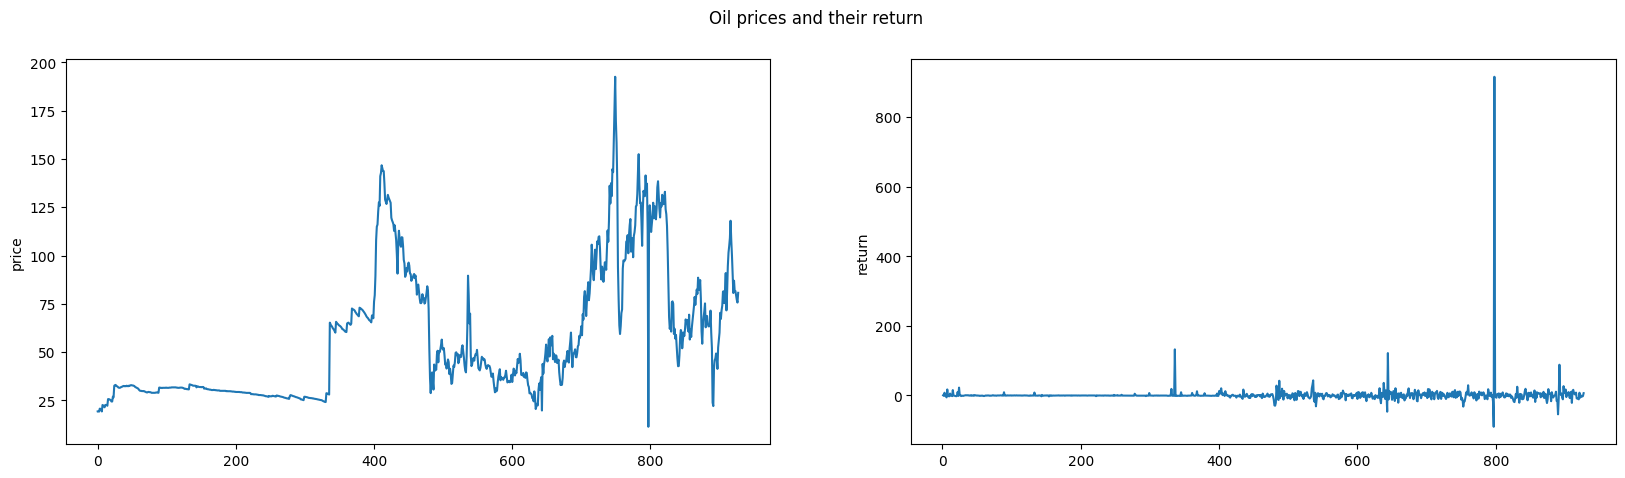

In [52]:
def plot_returns():
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
    fig.suptitle('Oil prices and their return')
    ax[0].plot(prices['Price'])
    ax[0].set_ylabel('price')
    ax[1].plot(returns)
    ax[1].set_ylabel('return')
    plt.plot()

plot_returns()

#### The price series does not look stationary, but the return series though fluctuating looks like stationary.

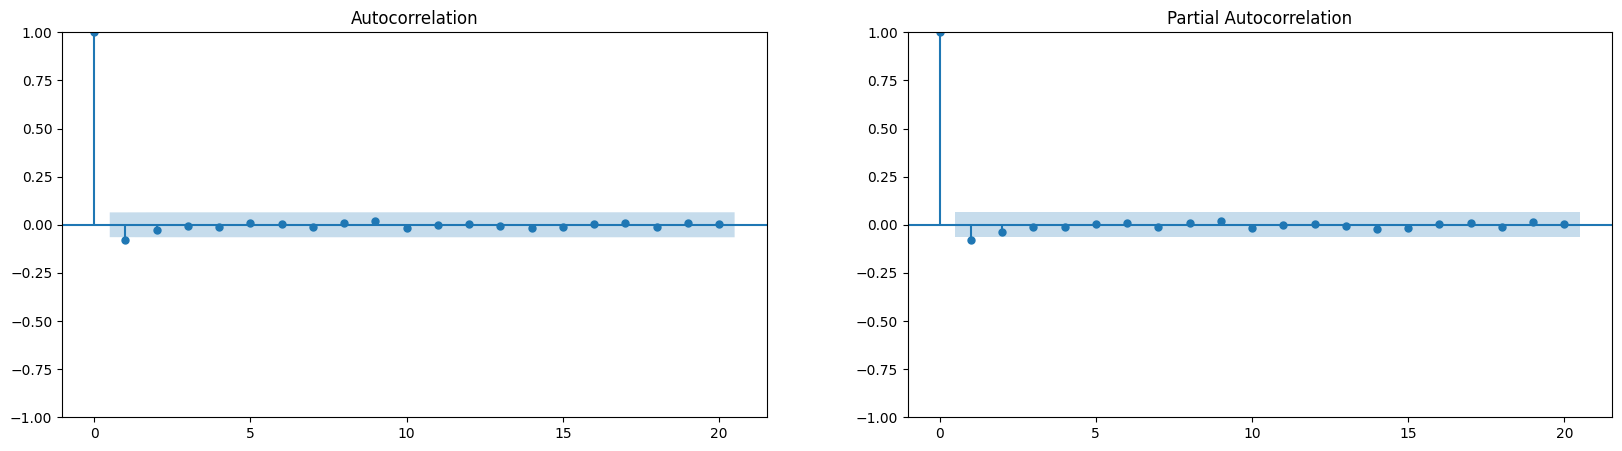

In [53]:
def plot_garch_ACF_PACF():
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
    plot_acf(returns, lags=20, ax=ax[0])
    plot_pacf(returns, lags=20, ax=ax[1])
    plt.plot()

plot_garch_ACF_PACF()

#### Here both ACF and PACF have only one significant lag, thus we'll go with ARMA(1,1)

In [31]:
model = ARIMA(returns,order=(1,0,1))
result = model.fit()

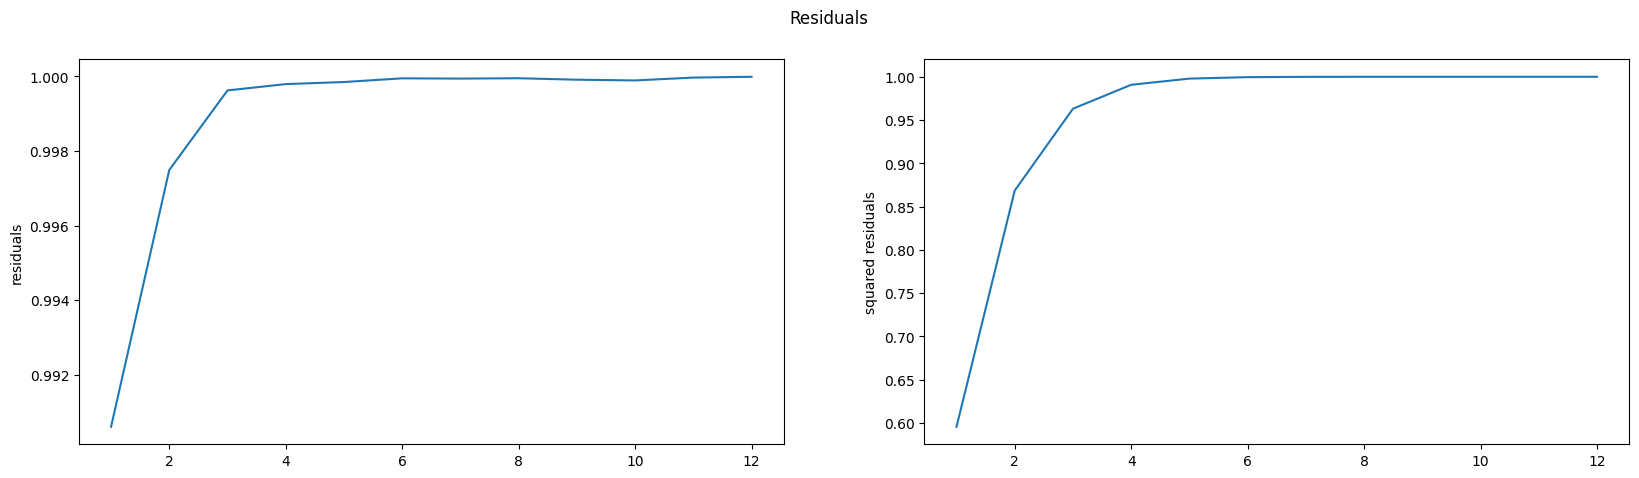

In [54]:
lj_box = acorr_ljungbox(result.resid, lags=12, return_df=True)# residuals
lj_box_sq = acorr_ljungbox(result.resid**2, lags=12, return_df=True)# squared residuals

def plot_resid():
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
    fig.suptitle('Residuals')
    ax[0].plot(lj_box.index, lj_box.lb_pvalue)
    ax[0].set_ylabel('residuals')
    ax[1].plot(lj_box_sq.index, lj_box_sq.lb_pvalue)
    ax[1].set_ylabel('squared residuals')
    plt.plot()

plot_resid()

#### We see that p-values for Ljung-Box are quite high, thus we fail to reject the null hypothesis and conclude that the data is independently distributed.

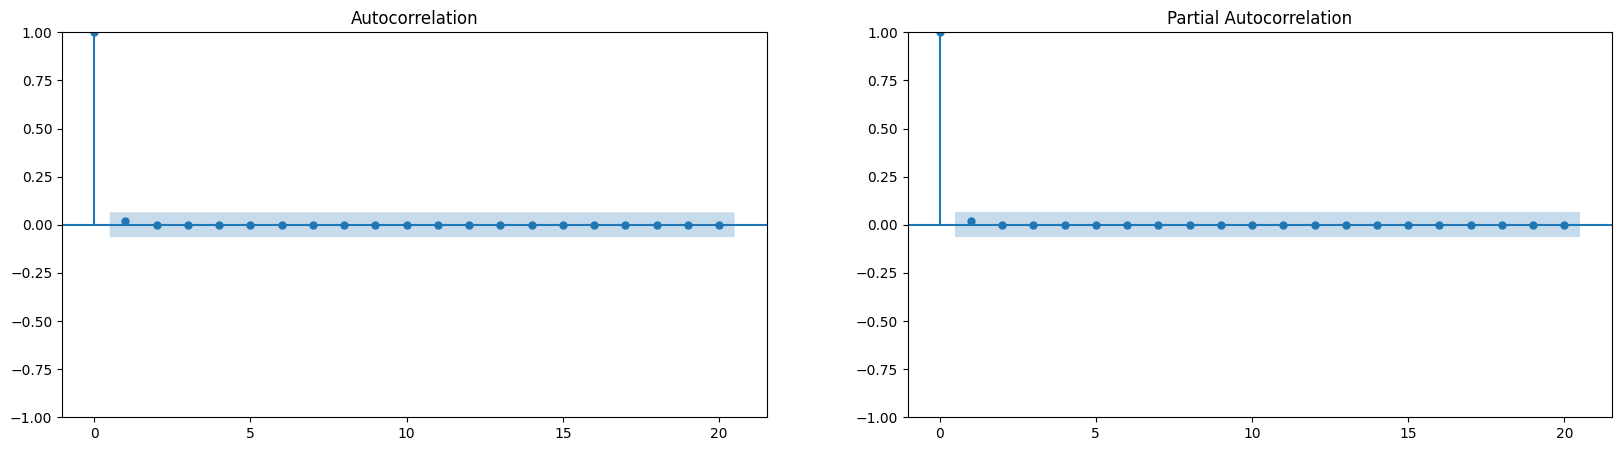

In [55]:
def resid_ACF_PACF():
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
    plot_acf(result.resid**2, lags=20, ax=ax[0])
    plot_pacf(result.resid**2, lags=20, ax=ax[1])
    plt.plot()

resid_ACF_PACF()

#### We see that no significant lags are present, thus we'll proceed with GARCH(1,1).

In [56]:
arma_residuals = result.resid
def find_best_p_and_q():
    best_aic = np.inf
    best_p = 0
    best_q = 0

    for p in range(1, 4):
        for q in range(4):
            if p == 0 and q == 0:
                continue
            try:
                gmodel = arch_model(arma_residuals, vol='GARCH', p=p, q=q)
                results = gmodel.fit(disp='off')
                aic = results.aic
                if aic < best_aic:
                    best_aic = aic
                    best_p = p
                    best_q = q
            except:
                pass

    print(f'Best GARCH({best_p},{best_q}) model with AIC = {best_aic:.2f}')
    return best_p, best_q

find_best_p_and_q()

C:\Users\mherm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\arch\univariate\base.py:756: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Best GARCH(1,2) model with AIC = 6379.08


(1, 2)

In [57]:
def garch_forecast_with_best_params(best_p, best_q):
    best_arch = arch_model(arma_residuals, mean='Zero', vol='Garch', p=best_p, o=0, q=best_q, dist='Normal')
    res = best_arch.fit(update_freq=5, disp='off')

    forecasts = res.forecast(horizon=12)
    print(forecasts.variance.dropna().head())
    return forecasts

garch_forecast_with_best_params(1, 2)

          h.01      h.02       h.03       h.04       h.05       h.06  \
927  31.043535  40.60782  38.516416  42.341384  43.163231  45.509448   

          h.07       h.08       h.09       h.10       h.11       h.12  
927  47.081903  49.047117  50.812968  52.680015  54.495697  56.337452  


          h.01      h.02       h.03       h.04       h.05       h.06  \
927  31.043535  40.60782  38.516416  42.341384  43.163231  45.509448   

          h.07       h.08       h.09       h.10       h.11       h.12  
927  47.081903  49.047117  50.812968  52.680015  54.495697  56.337452  


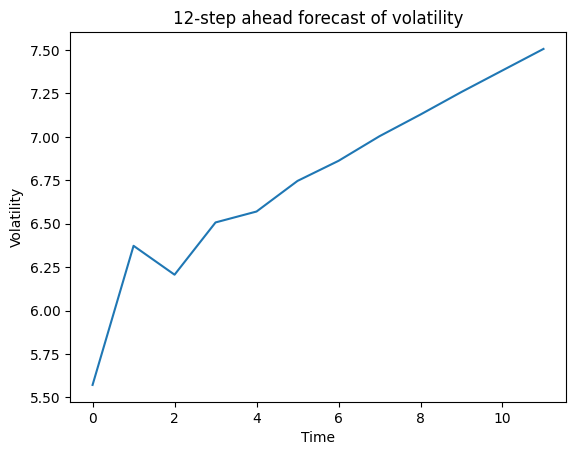

In [59]:
def volatility_forecast(forecasts):
    volatility = np.sqrt(forecasts.variance.values[-1, :])

    plt.plot(volatility)
    plt.title('12-step ahead forecast of volatility')
    plt.xlabel('Time')
    plt.ylabel('Volatility')
    plt.show()

volatility_forecast(garch_forecast_with_best_params(1, 2))

In [37]:
print('All code ran successfully')

All code ran successfully
